<h1>Proyecto 1</h1>

In [1]:
import pandas as pd
import nltk
import contractions
import inflect
import re, string
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score as AS
from sklearn.metrics import f1_score as F1
from sklearn.metrics import precision_score as PS
from sklearn.metrics import recall_score as RS
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

Se espera que corra en su computador el comando: 
- pip install contractions 
- pip install inflect

<h1>1. Entendimiento y preparación de datos</h1>

In [2]:
ruta = "./data/SuicidiosProyecto.csv"
df = pd.read_csv(ruta, encoding="utf-8", index_col=0)
df.columns

Index(['text', 'class'], dtype='object')

In [3]:
df.sample(5)

,text,class
Unnamed: 0,,
83478,"Man I'm pretty sure I'm not depressed, but I'm...",non-suicide
65928,has anyone tried psilocybin as a treatment?i k...,suicide
133341,Planning on killing myself on SundayI feel lik...,suicide
344091,I wonder what a eyelid Pearceing would feel li...,non-suicide
222808,"I'm no longer a teenager, but I know you guys ...",non-suicide


In [4]:
df.dtypes

text     object
class    object
dtype: object

In [5]:
df['class'].value_counts(dropna=False, normalize=True)

non-suicide    0.562928
suicide        0.437072
Name: class, dtype: float64

In [6]:
df['text'] = df['text'].str.encode('ascii', 'ignore').str.decode('ascii')

In [7]:
df['no_constractions'] = df['text'].apply(lambda x: [contractions.fix(word) for word in x.split()])

In [8]:
df['text'] = [' '.join(map(str, l)) for l in df['no_constractions']]

In [9]:
df['tokenized'] = df['text'].apply(nltk.word_tokenize)

In [10]:
df['tokenized'] = df['tokenized'].apply(lambda x: [word.lower() for word in x])

In [11]:
punc = string.punctuation
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in punc])

In [12]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
df['tokenized'] = df['tokenized'].apply(lambda x: [word for word in x if word not in stop_words])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\camil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
df['tokenized_str'] = [' '.join(map(str,l)) for l in df['tokenized']]
df.head()

,text,class,no_constractions,tokenized,tokenized_str
Unnamed: 0,,,,,
173271,i want to destroy myselffor once everything wa...,suicide,"[i, want, to, destroy, myselffor, once, everyt...","[want, destroy, myselffor, everything, startin...",want destroy myselffor everything starting fee...
336321,I kind of got behind schedule with learning fo...,non-suicide,"[I, kind of, got, behind, schedule, with, lear...","[kind, got, behind, schedule, learning, next, ...",kind got behind schedule learning next week te...
256637,I am just not sure anymoreFirst and foremost: ...,suicide,"[I am, just, not, sure, anymoreFirst, and, for...","[sure, anymorefirst, foremost, brazil, judge, ...",sure anymorefirst foremost brazil judge second...
303772,please give me a reason to liveThats too much ...,suicide,"[please, give, me, a, reason, to, liveThats, t...","[please, give, reason, livethats, much, reason...",please give reason livethats much reason live ...
293747,27f struggling to find meaning moving forwardI...,suicide,"[27f, struggling, to, find, meaning, moving, f...","[27f, struggling, find, meaning, moving, forwa...",27f struggling find meaning moving forwardi ad...


In [14]:
df.sample(5)

,text,class,no_constractions,tokenized,tokenized_str
Unnamed: 0,,,,,
123628,My best friend's cat has severe problems and i...,non-suicide,"[My, best, friend's, cat, has, severe, problem...","[best, friend, 's, cat, severe, problems, stre...",best friend 's cat severe problems stresses su...
157298,Today my grandma who I played minecraft passed...,non-suicide,"[Today, my, grandma, who, I, played, minecraft...","[today, grandma, played, minecraft, passed, aw...",today grandma played minecraft passed away use...
100626,"Stuck living, in a perpetual hell.I have poste...",suicide,"[Stuck, living,, in, a, perpetual, hell.I have...","[stuck, living, perpetual, hell.i, posted, man...",stuck living perpetual hell.i posted many coun...
320058,man i just shaved down there Ngl really turned...,non-suicide,"[man, i, just, shaved, down, there, Ngl, reall...","[man, shaved, ngl, really, turned, right, like...",man shaved ngl really turned right like gets r...
216222,Anyone want to trade brains Everytime i close ...,non-suicide,"[Anyone, want to, trade, brains, Everytime, i,...","[anyone, want, trade, brains, everytime, close...",anyone want trade brains everytime close eyes/...


In [15]:
df.to_csv('SuicidiosLimpios.csv')

In [18]:
x_train, x_test, y_train, y_test = train_test_split(df['tokenized_str'], df['class'], test_size=0.3, random_state=28)

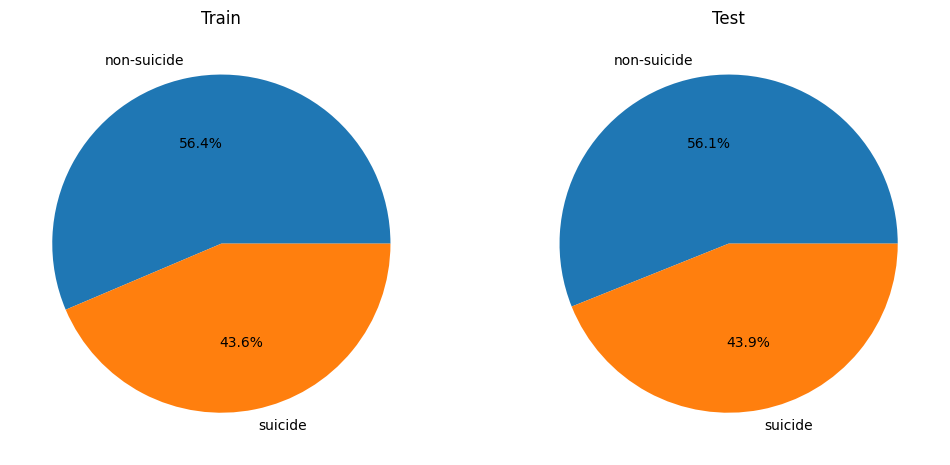

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].pie(y_train.value_counts(), labels=y_train.value_counts().index, autopct='%1.1f%%')
ax[0].set_title('Train')
ax[1].pie(y_test.value_counts(), labels=y_test.value_counts().index, autopct='%1.1f%%')
ax[1].set_title('Test')
plt.show()

In [17]:
bow = CountVectorizer(tokenizer = nltk.word_tokenize)
x_train_bow = bow.fit_transform(x_train)
x_test_bow = bow.transform(x_test)
len(bow.get_feature_names())

c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


155565

In [19]:
tfidf = TfidfVectorizer(tokenizer=nltk.word_tokenize)
x_train_tfidf = tfidf.fit_transform(x_train)
x_test_tfidf = tfidf.transform(x_test)
len(tfidf.get_feature_names())

c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


155565

<h2>Arboles de decisión</h2>

<h3>Decision Tree con TF-IDF</h3>

In [102]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [103]:
f1 = make_scorer(f1_score, average='micro')

In [104]:
param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 120, 140, 160, 180, 200],
              'criterion' :['gini', 'entropy']
             }

In [105]:
dtTF_IDF = DecisionTreeClassifier(random_state = 30)

In [106]:
grid_search = GridSearchCV(estimator=dtTF_IDF, param_grid=param_grid, cv=5, verbose=True, scoring = f1)
grid_search.fit(x_train_tfidf, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=30),
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       120, 140, 160, 180, 200],
                         'max_features': ['auto', 'sqrt', 'log2']},
             scoring=make_scorer(f1_score, average=micro), verbose=True)

In [107]:
final_model = grid_search.best_estimator_

In [108]:
final_model

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=80, max_features='auto',
                       random_state=30)

In [109]:
final_model.fit(x_train_tfidf, y_train)

c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(ccp_alpha=0.001, max_depth=80, max_features='auto',
                       random_state=30)

<AxesSubplot:>

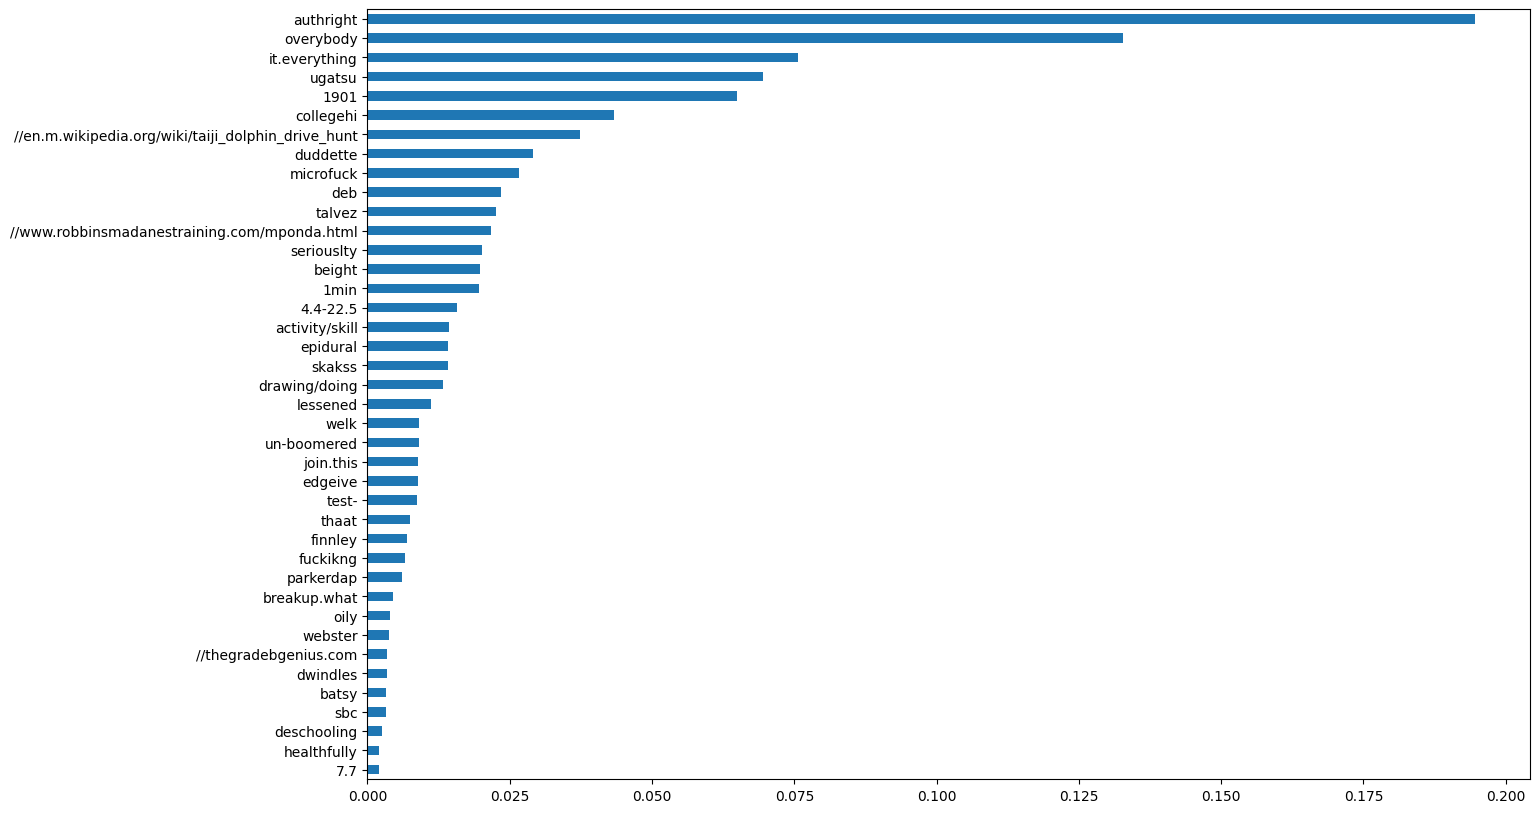

In [110]:
pd.Series(final_model.feature_importances_, index = tfidf.vocabulary_).sort_values().tail(40).plot.barh(figsize = (15, 10))

In [111]:
y_train_dt_tfidf_predict = final_model.predict(x_train_tfidf)
y_test_dt_tfidf_predict = final_model.predict(tfidf.transform(x_test))

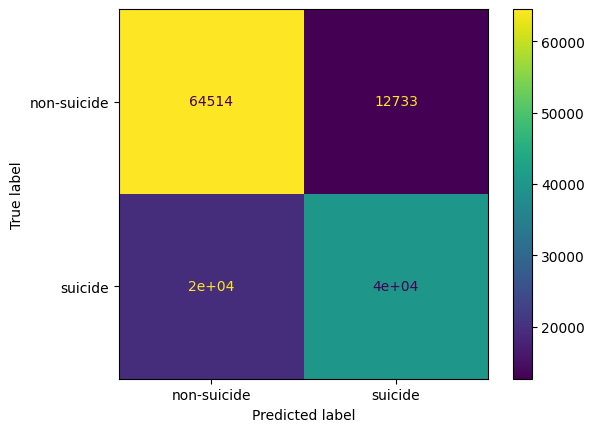

In [112]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_dt_tfidf_predict)

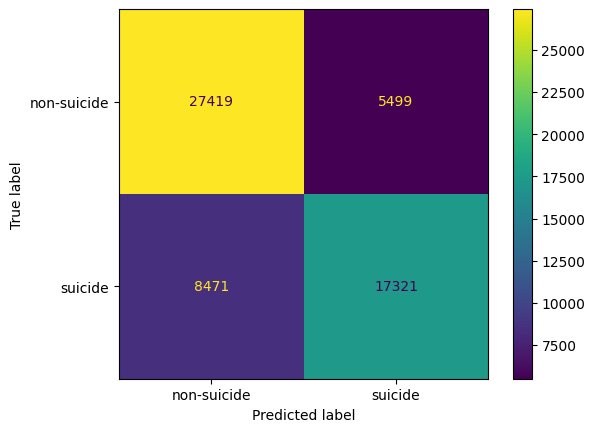

In [113]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_dt_tfidf_predict)

In [114]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [115]:
if len(final_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_dt_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_dt_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_dt_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_dt_tfidf_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_dt_tfidf_predict, average = None))
    print('F1:', f1_score(y_train, y_train_dt_tfidf_predict, average = None))

Precision: 0.7596050370985709
Recall: 0.6734512829954974
F1: 0.7139384260491527


In [116]:
if len(final_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_dt_tfidf_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_dt_tfidf_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_dt_tfidf_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_dt_tfidf_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_dt_tfidf_predict, average = None))
    print('F1:', f1_score(y_test, y_test_dt_tfidf_predict, average = None))

Precision: 0.7590271691498686
Recall: 0.6715648263027295
F1: 0.7126223977618694


<h3>Almacenando el mejor modelo</h3>

In [16]:
import pickle

In [17]:
mejor_model = DecisionTreeClassifier(ccp_alpha=0.001, max_depth=80, max_features='auto',
                       random_state=30)

In [20]:
mejor_model.fit(x_train_tfidf, y_train)

c:\Users\camil\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\tree\_classes.py:298: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(


DecisionTreeClassifier(ccp_alpha=0.001, max_depth=80, max_features='auto',
                       random_state=30)

In [21]:
nombre="bestDecisionTreeClassifier.pkl"
pickle.dump(mejor_model,open(nombre,"wb"))